# Earthquake Data Training and Analysis

This notebook trains models to predict earthquake magnitude and analyzes the results.

In [ ]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline

In [2]:
import os
import pandas as pd

BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, "data", "all_month.csv")

print("DATA PATH:", DATA_PATH)
print("File exists:", os.path.exists(DATA_PATH))

raw_df = pd.read_csv(DATA_PATH)

print("Dataset loaded successfully!")
print("Shape:", raw_df.shape)
print(raw_df.head())


DATA PATH: d:\AI\Earthquake_AI_Project\data\all_month.csv
File exists: True
Dataset loaded successfully!
Shape: (8898, 22)
                       time   latitude   longitude      depth       mag  \
0  2025-12-07T18:04:08.954Z  60.471104 -139.604202   5.000000  4.881606   
1  2025-12-07T18:02:33.440Z  33.584833 -116.745167  15.620000  0.570000   
2  2025-12-07T17:59:09.150Z  34.916333 -119.041667  13.830000  1.470000   
3  2025-12-07T17:50:30.834Z  60.271606 -139.455078   5.000000  3.946544   
4  2025-12-07T17:47:11.911Z  60.456127 -139.583618  11.747114  4.135578   

  magType    nst        gap      dmin       rms  ...  \
0      ml   66.0  53.124756  0.496044  1.575235  ...   
1      ml   11.0  85.000000  0.020460  0.080000  ...   
2      ml   55.0  44.000000  0.084460  0.240000  ...   
3      ml   39.0  77.858941  0.435755  1.453563  ...   
4      ml  143.0  53.045027  0.491682  1.892219  ...   

                    updated                        place        type  \
0  2025-12-07T18:

In [3]:
def save_plot(filename: str):
    """Save current matplotlib figure into static/plots and show it."""
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, filename), dpi=200)
    plt.show()

def plot_before_training(raw_df: pd.DataFrame):
    """Visualizations BEFORE cleaning/training (raw dataset)."""

    # Missing values (top 15)
    missing = raw_df.isna().sum().sort_values(ascending=False)
    plt.figure()
    missing.head(15).plot(kind="bar")
    plt.title("Missing Values (Top 15 Columns) - BEFORE Cleaning")
    plt.xlabel("Columns")
    plt.ylabel("Missing count")
    save_plot("before_missing_values.png")

    # Magnitude histogram
    if "mag" in raw_df.columns:
        plt.figure()
        raw_df["mag"].dropna().plot(kind="hist", bins=40)
        plt.title("Magnitude Distribution - BEFORE Cleaning")
        plt.xlabel("Magnitude (mag)")
        plt.ylabel("Frequency")
        save_plot("before_mag_hist.png")

    # Depth vs Magnitude scatter
    if {"depth", "mag"}.issubset(raw_df.columns):
        plt.figure()
        plt.scatter(raw_df["depth"], raw_df["mag"], s=8)
        plt.title("Depth vs Magnitude - BEFORE Cleaning")
        plt.xlabel("Depth (km)")
        plt.ylabel("Magnitude (mag)")
        save_plot("before_depth_vs_mag.png")

def plot_after_cleaning(clean_df: pd.DataFrame):
    """Visualizations AFTER cleaning (correlation heatmap)."""
    numeric_cols = clean_df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) >= 2:
        corr = clean_df[numeric_cols].corr(numeric_only=True)

        plt.figure(figsize=(10, 8))
        plt.imshow(corr.values, aspect="auto")
        plt.title("Correlation Heatmap (Numeric Features) - AFTER Cleaning")
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.index)), corr.index)
        plt.colorbar()
        save_plot("after_corr_heatmap.png")

def plot_after_training(y_true, y_pred, title_prefix: str, filename_prefix: str):
    """Plots AFTER training (actual vs predicted + residuals)."""
    # Actual vs Predicted
    plt.figure()
    plt.scatter(y_true, y_pred, s=10)
    plt.title(f"{title_prefix}: Actual vs Predicted")
    plt.xlabel("Actual magnitude")
    plt.ylabel("Predicted magnitude")
    save_plot(f"{filename_prefix}_actual_vs_pred.png")

    # Residual plot
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, s=10)
    plt.axhline(0)
    plt.title(f"{title_prefix}: Residual Plot")
    plt.xlabel("Predicted magnitude")
    plt.ylabel("Residual (Actual - Predicted)")
    save_plot(f"{filename_prefix}_residuals.png")

In [26]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

raw_df = pd.read_csv(DATA_PATH)
raw_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-12-07T18:04:08.954Z,60.471104,-139.604202,5.000000,4.881606,ml,66.0,53.124756,0.496044,1.575235,...,2025-12-07T18:14:29.610Z,"103 km N of Yakutat, Alaska",earthquake,0.00,0.000000,0.256384,45.0,reviewed,ak,ak
1,2025-12-07T18:02:33.440Z,33.584833,-116.745167,15.620000,0.570000,ml,11.0,85.000000,0.020460,0.080000,...,2025-12-07T18:06:12.417Z,"7 km WNW of Anza, CA",earthquake,0.54,1.020000,0.129064,11.0,automatic,ci,ci
2,2025-12-07T17:59:09.150Z,34.916333,-119.041667,13.830000,1.470000,ml,55.0,44.000000,0.084460,0.240000,...,2025-12-07T18:02:52.949Z,"11 km WSW of Grapevine, CA",earthquake,0.24,0.400000,0.248337,27.0,automatic,ci,ci
3,2025-12-07T17:50:30.834Z,60.271606,-139.455078,5.000000,3.946544,ml,39.0,77.858941,0.435755,1.453563,...,2025-12-07T17:58:37.827Z,"82 km N of Yakutat, Alaska",earthquake,0.00,0.000000,0.271307,25.0,reviewed,ak,ak
4,2025-12-07T17:47:11.911Z,60.456127,-139.583618,11.747114,4.135578,ml,143.0,53.045027,0.491682,1.892219,...,2025-12-07T18:03:19.780Z,"101 km N of Yakutat, Alaska",earthquake,0.00,3.282911,0.314645,87.0,reviewed,ak,ak


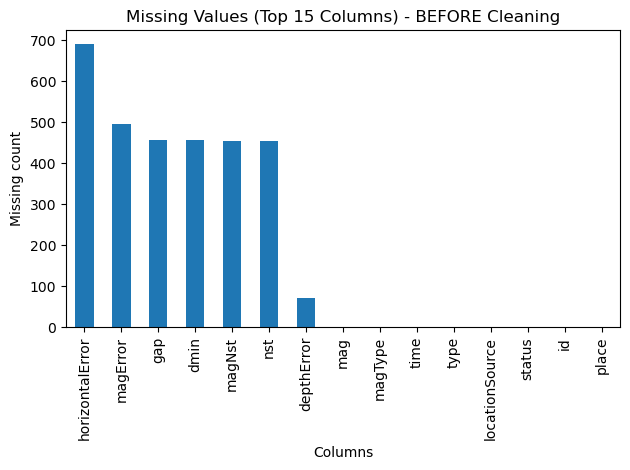

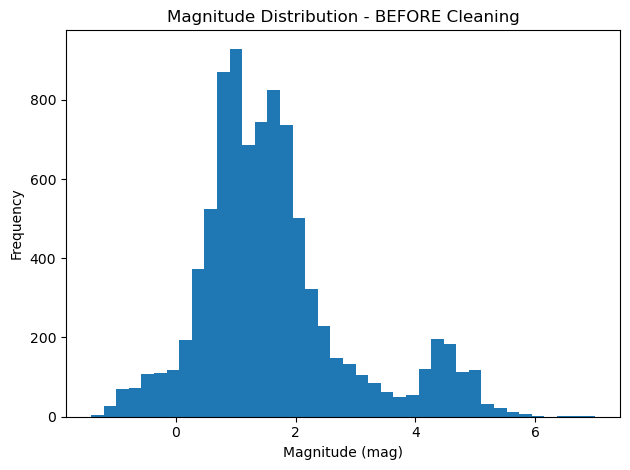

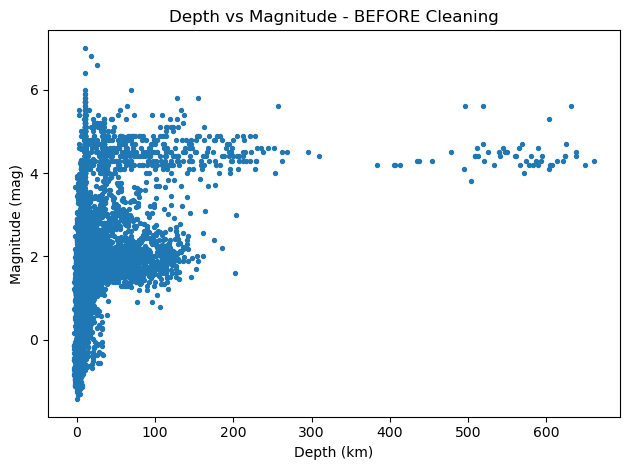

In [27]:
plot_before_training(raw_df)

In [28]:
df = raw_df.drop_duplicates().copy()

# convert numeric columns safely
numeric_candidates = [
    "latitude", "longitude", "depth", "mag",
    "nst", "gap", "dmin", "rms",
    "horizontalError", "depthError", "magError", "magNst"
]
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

target = "mag"

feature_cols = [
    "latitude", "longitude", "depth",
    "nst", "gap", "dmin", "rms",
    "horizontalError", "depthError", "magError", "magNst"
]
feature_cols = [c for c in feature_cols if c in df.columns]

# drop rows where target missing
df = df.dropna(subset=[target])

# keep only needed columns
model_df = df[feature_cols + [target]].copy()

print(f"Cleaned dataset shape: {model_df.shape}")
model_df.head()

Cleaned dataset shape: (8897, 12)


,latitude,longitude,depth,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,mag
0,60.471104,-139.604202,5.000000,66.0,53.124756,0.496044,1.575235,0.00,0.000000,0.256384,45.0,4.881606
1,33.584833,-116.745167,15.620000,11.0,85.000000,0.020460,0.080000,0.54,1.020000,0.129064,11.0,0.570000
2,34.916333,-119.041667,13.830000,55.0,44.000000,0.084460,0.240000,0.24,0.400000,0.248337,27.0,1.470000
3,60.271606,-139.455078,5.000000,39.0,77.858941,0.435755,1.453563,0.00,0.000000,0.271307,25.0,3.946544
4,60.456127,-139.583618,11.747114,143.0,53.045027,0.491682,1.892219,0.00,3.282911,0.314645,87.0,4.135578


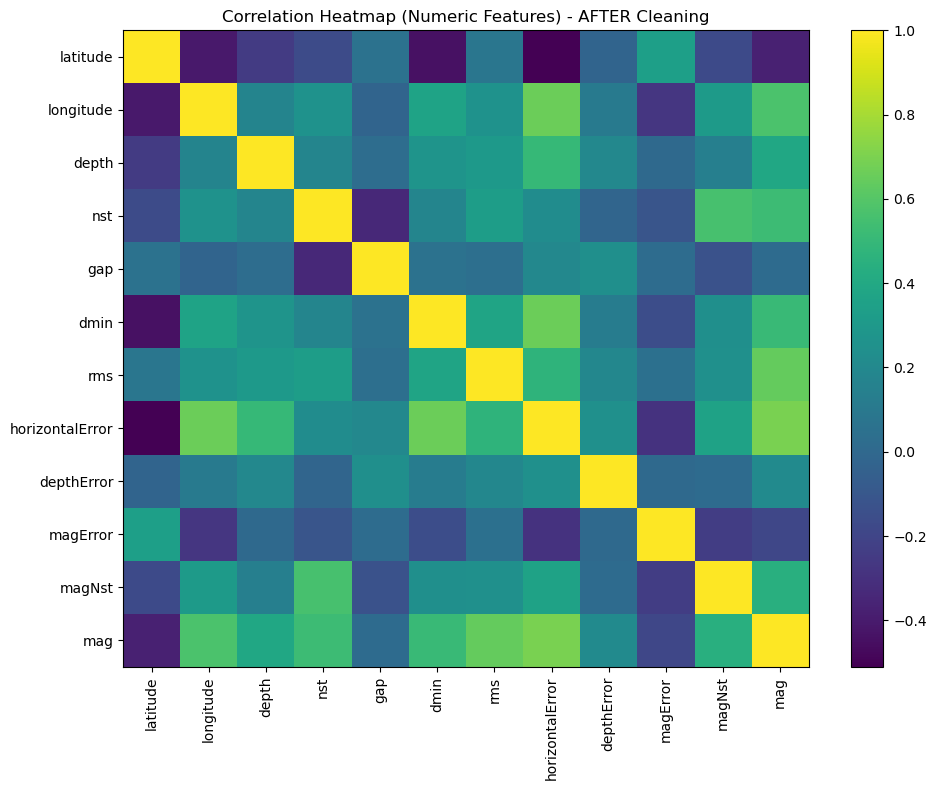

In [29]:
plot_after_cleaning(model_df)

In [30]:
X = model_df[feature_cols]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (7117, 11)
Testing shape: (1780, 11)


Training Linear Regression...
  MAE: 0.4746, RMSE: 0.6142, R2: 0.7739


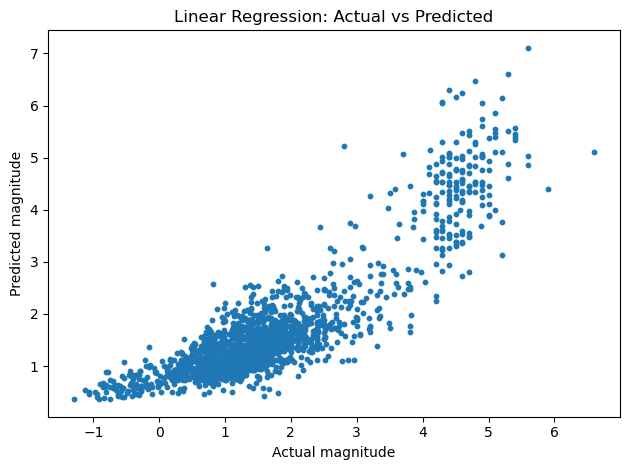

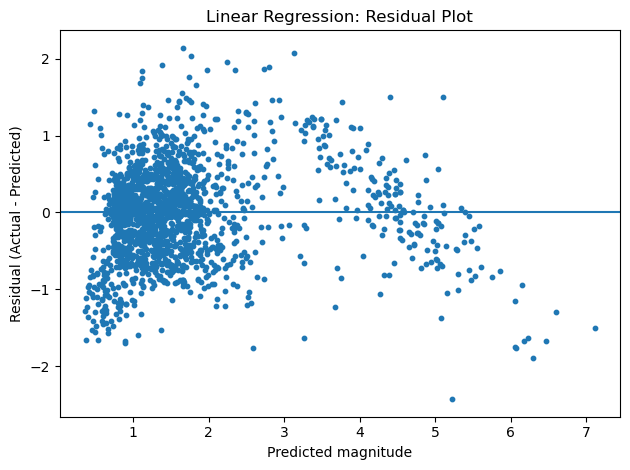

Training KNN...
  MAE: 0.3064, RMSE: 0.4219, R2: 0.8933


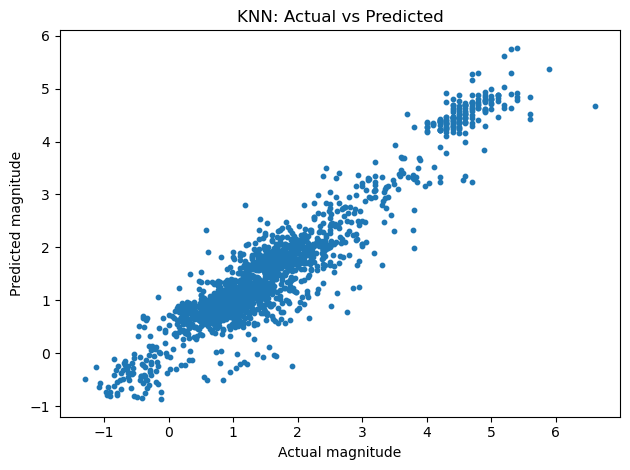

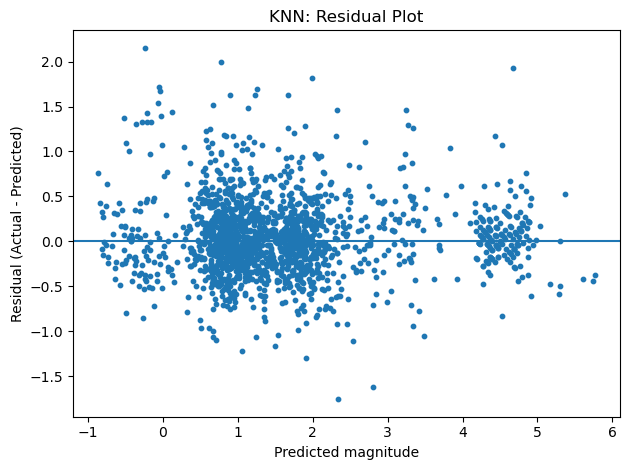

Training Random Forest...
  MAE: 0.2331, RMSE: 0.3238, R2: 0.9372


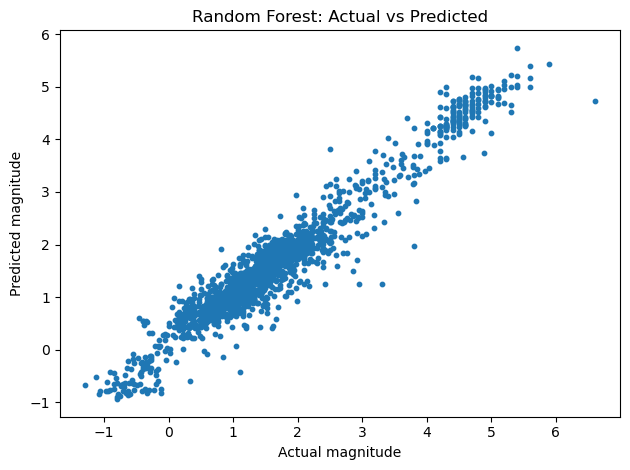

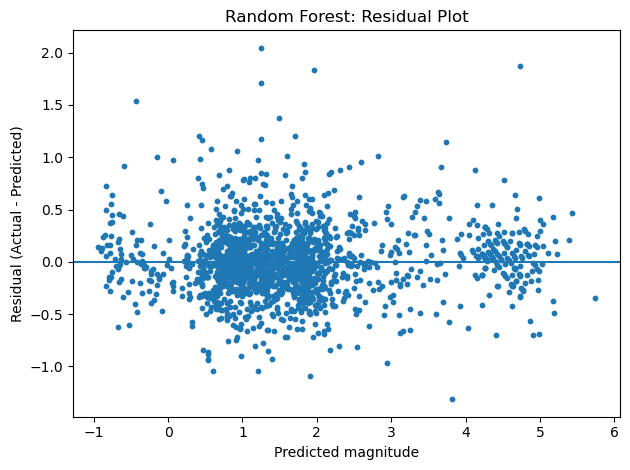

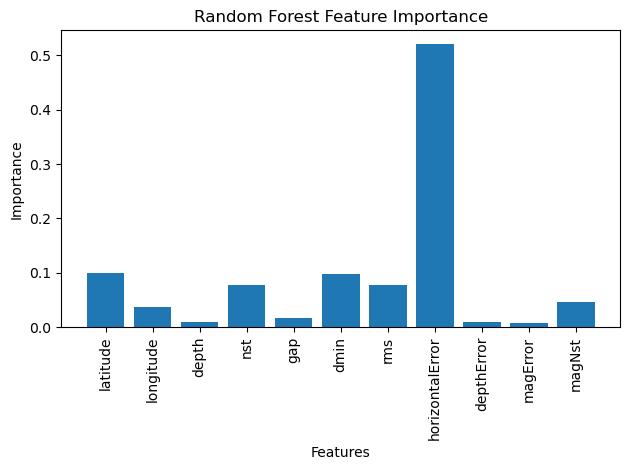

In [31]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=7),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
}

pipelines = {}
metrics = {}

for name, model in models.items():
    print(f"Training {name}...")
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = float(mean_absolute_error(y_test, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = float(r2_score(y_test, y_pred))

    pipelines[name] = pipe
    metrics[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    
    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # AFTER training plots per model
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
    plot_after_training(
        y_true=y_test.values,
        y_pred=y_pred,
        title_prefix=name,
        filename_prefix=f"after_{safe_name}"
    )

    # Feature importance for Random Forest
    if name == "Random Forest":
        try:
            rf = pipe.named_steps["model"]
            importances = rf.feature_importances_
            plt.figure()
            plt.bar(feature_cols, importances)
            plt.title("Random Forest Feature Importance")
            plt.xlabel("Features")
            plt.ylabel("Importance")
            plt.xticks(rotation=90)
            save_plot("after_rf_feature_importance.png")
        except Exception:
            pass

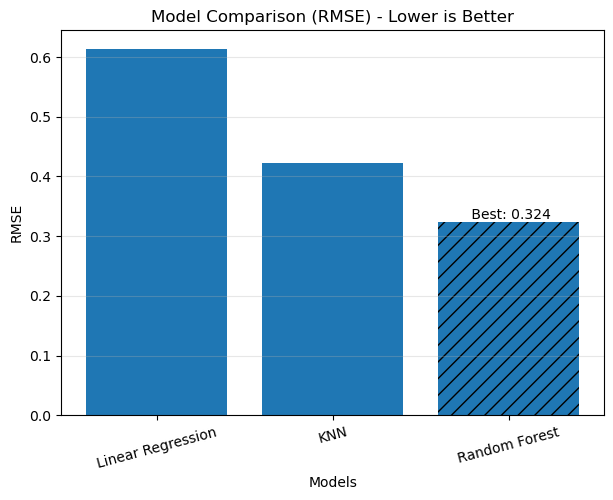

In [6]:
import json
import matplotlib.pyplot as plt

with open("model/metrics.json", "r") as f:
    metrics_pack = json.load(f)

metrics = metrics_pack["metrics"]
best_model = metrics_pack["best_model_name"]

model_names = list(metrics.keys())
rmses = [metrics[m]["RMSE"] for m in model_names]

plt.figure(figsize=(7,5))
bars = plt.bar(model_names, rmses)
plt.title("Model Comparison (RMSE) - Lower is Better")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.grid(True, axis="y", alpha=0.3)

# highlight best
best_index = model_names.index(best_model)
bars[best_index].set_hatch("//")
plt.text(best_index, rmses[best_index], f" Best: {rmses[best_index]:.3f}",
         ha="center", va="bottom")

plt.show()


In [33]:
# Save model pack (keys match app.py)
model_pack = {
    "feature_cols": feature_cols,
    "best_model_name": best_model_name,
    "pipelines": pipelines,
}
joblib.dump(model_pack, os.path.join(MODEL_DIR, "models.pkl"))

# Save metrics pack (contains "metrics")
metrics_pack = {
    "metrics": metrics,
    "best_model_name": best_model_name,
    "best_model_rmse": best_rmse,
    "feature_cols": feature_cols,
}
with open(os.path.join(MODEL_DIR, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_pack, f, indent=2)

print("Saved: model/models.pkl, model/metrics.json")
print("Plots: static/plots/")

Saved: model/models.pkl, model/metrics.json
Plots: static/plots/
